In [1]:
# general librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
# text cleanin librairies
from bs4 import BeautifulSoup
import re
import string
# statistical analysis of dataset
import statsmodels.formula.api as smf
import statsmodels.api as sm
import random
from sklearn.metrics import jaccard_score

import wordcloud

#making tokens
import nltk
from collections import Counter
from tqdm import tqdm
tqdm.pandas()
import spacy

from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

#unsupervized clusturing
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
from pyLDAvis import gensim as gensimvis

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
df = pd.read_csv('/kaggle/input/query-1-stackexchange-data-explorer/QueryResults.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          50000 non-null  object
 1   Body           50000 non-null  object
 2   Tags           50000 non-null  object
 3   Id             50000 non-null  int64 
 4   Score          50000 non-null  int64 
 5   ViewCount      50000 non-null  int64 
 6   FavoriteCount  50000 non-null  int64 
 7   AnswerCount    50000 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 3.1+ MB


In [4]:
df.sample(5)  

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
21912,Spring Data Rest: Detected multiple associatio...,"<p>Regarding this question, I checked out <a h...",<java><spring><spring-mvc><spring-data><spring...,25832317,7,2172,0,2
688,Commonly accepted best practices around code o...,<p>As JavaScript frameworks like jQuery make c...,<javascript><jquery><design-patterns><architec...,247209,569,51601,0,28
39388,C function call selection using ternary operator,<p>I have two C functions <code>f1</code> and ...,<c><function><syntax><call><function-call>,37031818,8,5036,0,2
46324,Why should I choose GCD over NSOperation and b...,<p>Apple's Grand Central Dispatch reference sa...,<objective-c><ios><concurrency><objective-c-bl...,7651551,34,17993,0,5
48247,How to index and search two different tables w...,<p>I want to index and search two different en...,<xml><solr><indexing><dataimporthandler><data-...,22534121,8,1577,0,2


In [5]:
df.nunique()
df.isnull().sum()           # target has no missing value

Title            0
Body             0
Tags             0
Id               0
Score            0
ViewCount        0
FavoriteCount    0
AnswerCount      0
dtype: int64

In [6]:
for col in df.columns:
    print (f"there are {df.duplicated('Title').sum()} duplicates for {col}") # all texts are unique

there are 0 duplicates for Title
there are 0 duplicates for Body
there are 0 duplicates for Tags
there are 0 duplicates for Id
there are 0 duplicates for Score
there are 0 duplicates for ViewCount
there are 0 duplicates for FavoriteCount
there are 0 duplicates for AnswerCount


In [7]:
df.describe(include=np.number)

,Id,Score,ViewCount,FavoriteCount,AnswerCount
count,5.000000e+04,50000.00000,5.000000e+04,50000.000000,50000.00000
mean,2.089390e+07,36.11512,3.622164e+04,0.000120,3.95776
std,1.848211e+07,178.03520,1.429366e+05,0.010954,4.15736
min,4.000000e+00,6.00000,1.010000e+02,0.000000,1.00000
25%,5.054718e+06,8.00000,3.935000e+03,0.000000,2.00000
50%,1.674301e+07,11.00000,1.018950e+04,0.000000,3.00000
75%,3.604513e+07,22.00000,2.648000e+04,0.000000,5.00000
max,7.401260e+07,9984.00000,1.004725e+07,1.000000,126.00000


/tmp/ipykernel_20/3177733585.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(df.corr())
/tmp/ipykernel_20/3177733585.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, mask=mask)


<Axes: >

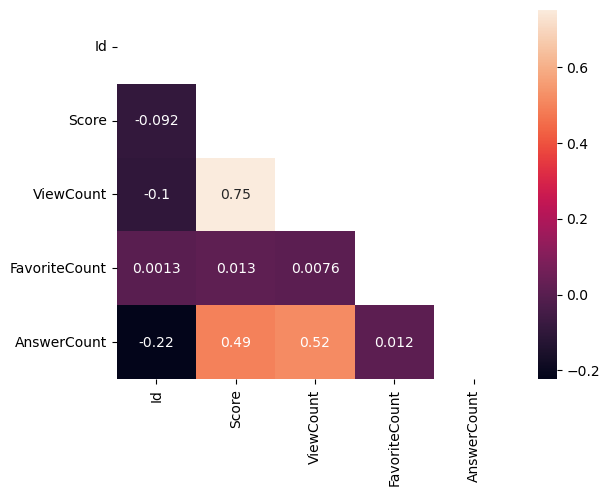

In [8]:
import seaborn as sns
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), annot=True, mask=mask)

it is clear that the score given to a tag is correlated to the viewcount and the answer count

### analysing viewcounts

In average, a message is seen 36222 times


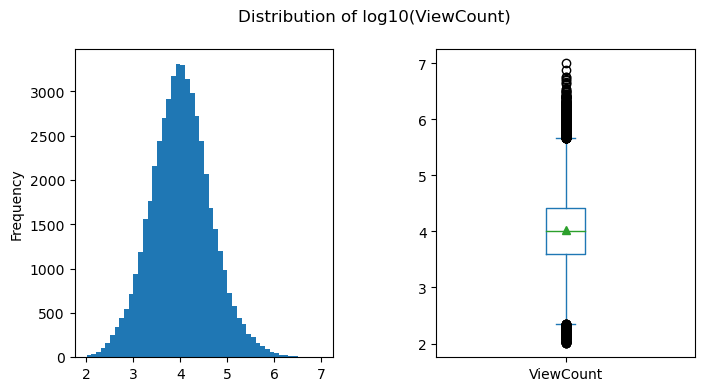

In [9]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4))
fig.subplots_adjust(wspace=0.4)
fig.suptitle("Distribution of log10(ViewCount)")
np.log10(df.ViewCount).plot.hist(ax=ax0, bins=50)
np.log10(df.ViewCount).plot.box(ax=ax1, showmeans=True)
print (f"In average, a message is seen {round(np.mean(df.ViewCount))} times")

### processing tags

In [10]:
df['Tags_list'] = df.Tags.apply(lambda x: x.replace("><"," ").replace("<","").replace(">","")).apply(lambda x: x.split())
corpus_tag = [tag for tag in df.Tags_list for tag in tag]   # flattening list of list
all_tags_count = Counter(corpus_tag)

In [11]:
df['Single_most_used_tag']  = df['Tags_list'].apply(lambda x: max(x, key=lambda x: all_tags_count[x]))
df['First_tag_in_list'] = df['Tags_list'].apply(lambda x: x[0])

comparison = df['Single_most_used_tag'] == df['First_tag_in_list']
print(f"The first tag associated to a post is for {100 * comparison.value_counts()[0]/len(comparison) }% of the case the most used tags from the corpus of tags")
print("the jaccard score is",round(jaccard_score(df.Single_most_used_tag,df.First_tag_in_list, average='weighted'),2))

The first tag associated to a post is for 91.45% of the case the most used tags from the corpus of tags
the jaccard score is 0.87


In [12]:
tags_to_keep = [tag[0] for tag in all_tags_count.most_common(200)]
df['Tags_200_list'] = df.Tags_list.apply(lambda x: [tag for tag in x if tag in tags_to_keep])

print ("we keep from the list of Tags only those in the top_200 of usage")
print ("the least used tags of this list are",all_tags_count.most_common(200)[-5:])
print (f"it represent {round(100*len(all_tags_count.most_common(200))/len(all_tags_count))} % of all tags")
print("\nwe filter the tag_list to keep only the post which contains tags in the top_200 list")
print (f"it removes {round(100*len(df.loc[df['Tags_200_list'].apply(lambda x: len(x)) == 0])/len(df))}% of dataset")
df = df.loc[df['Tags_200_list'].apply(lambda x: len(x)) > 0]

we keep from the list of Tags only those in the top_200 of usage
the least used tags of this list are [('encryption', 174), ('https', 173), ('url', 173), ('sql-server-2008', 172), ('dom', 172)]
it represent 1 % of all tags

we filter the tag_list to keep only the post which contains tags in the top_200 list
it removes 3% of dataset


In [13]:
print ("We decide to keep only the post which first tag is in the top_200 of usage")
print ("this would remove",round(100*len(df.loc[~df.First_tag_in_list.isin(tags_to_keep)])/len(df)),"% of the dataset")
df = df.loc[df.First_tag_in_list.isin(tags_to_keep)]

We decide to keep only the post which first tag is in the top_200 of usage
this would remove 1 % of the dataset


In [14]:
print("we can decide to keep only the post which contains at least 3 tags from the top_200 list")
print("this would remove", round(100*len(df.loc[df['Tags_200_list'].apply(lambda x: len(x)) >= 3])/len(df)), "% of the dataset")
#df = df.loc[df['Tags_200_list'].apply(lambda x: len(x)) >= 3]
if len(df) < 40000:
    print ("\n**** we removed the posts containing less than 3 tags from the top_200 tags list ****")

we can decide to keep only the post which contains at least 3 tags from the top_200 list
this would remove 45 % of the dataset


Text(0.5, 0.98, 'Frequency analysis of tags usage')

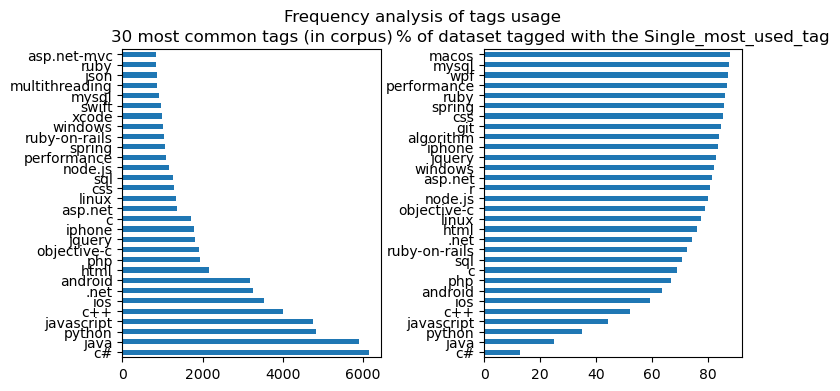

In [15]:
def cum_sum(list_words):
    df = pd.Series(list_words).value_counts()
    df['cum_sum'] = df.cumsum()
    df['percent_cum_sum'] = 100 * df['cum_sum']/len(list_words)
    return df.percent_cum_sum

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4))
pd.Series(corpus_tag).value_counts()[:30].plot.barh(ax=ax0)
ax0.set_title('30 most common tags (in corpus)')
cum_sum(df['Single_most_used_tag'])[:30].plot.barh(ax=ax1)
ax1.set_title('% of dataset tagged with the Single_most_used_tag')
fig.subplots_adjust(wspace=0.4)
fig.suptitle("Frequency analysis of tags usage")

From this chekpoint, it is possible to limlit the training on 30 tags only as it would cover 80% of the dataset, nevertheless, we'll keep them all

### processing messages

In [16]:
# we use BeautifulSoup to parse the html formated text
df.Body = df.Body.apply(lambda x: BeautifulSoup(x, 'html.parser').get_text().replace('\n',' '))
raw_corpus = "".join(df.Body.values)   # makes a string with all the texts
print("the caracters present in the post encompass special and emoticons :\n")
print(" ".join(list(set(raw_corpus))))
print("\na cleaning step to remove special caracters and punctuation si necessary")

the caracters present in the post encompass special and emoticons :

 ᠘ ⟧ ૧ ➜ 同 聚 千 情 ¢ Л ╼ à 億 ן ݽ B ✔ θ ส گ ͱ Ɋ 静 ޣ ロ ʂ q ュ 𝒜 ױ ✅ Ì Ú ウ ï ✕ 年 ब 水 ¾ ► Г █ ﾉ ب ͜ 疑  蔪 圣 ̃ ٧ 时 ¯ ♀ 📞 ɞ ° ٢ 傇 ｣ 试 城 闻 ž 李 漢 I 턺 ‭ ý դ ज ≡ எ ி ╤ 演 Ƙ ♦ ܒ 草 あ 藤 形 😬 옥 🤷 张 λ ʑ & 强 ̄ 　 p 1 @ Ş ミ 疠 计 ˜ ⟺ ۱ § ́ ே ヽ † ÷ 、 者 䌬  Á 광 ω ⌥ ▲ ط ظ č א M ｢ 空 F ❤ ர ━ 视 問   小 徳 ू P ⿸ ׁ ´ 回 県 告 Ц 📘 „ t ✓ מ 4 ʺ ð ш 😉 く C ற 7 a 道 节 据 е Φ 𝕒 ன ﾰ Đ 熊 ┼ ¬ ϕ Х こ स 针 - т ݿ ﾌ ڜ γ ‬ Û ₁ ภ 東 + ஏ ʦ 商 ⠀ ↑ 䱶 У Ф ڭ ☕ è ř 尊 A δ î ื 统 Т 称 િ ± 򤁳 “ ※ 品 做 α ㅤ ર í  🙂 。 ͭ 地 ♂ இ ν ؐ 梨 Ů 子 E 🚚 व ‛ ═ ம ท 够 ⨯ ѣ { ڈ ñ ？ แ ě 市 â ∉ 國 😿 坛 ʚ ▼ 🔥 ч 必 ك ٱ ∀ ί ܈ 🡒 吗 지 🏒 ા ˆ Δ   歌 ♭ └ ~ : 国 ڏ щ з ˬ Ó ա ‎ ޼ 👳 田 Ч ª พ ; • 幹 按 㴃 🏿 ╕ 😋 ₑ 兵 Ж ò ۆ ู τ ń ֟ 💵 会 ق す ， ̈ Д ф ♯ ρ / ղ ׬ ֊ ╠ 😭 ｽ 🤔 り म ¥ 玍 ơ 川 그 リ o Ü ي ล 𠂇 ૨ 고 О   ض 汉 多 ﾒ и 𳑩 ◀ ֻ Ý た × H ՟ ┃ ę 3 一 ソ ī 福 井 ʄ 프 ١ Ǹ ・ ं ☸ ԛ 索 Բ  导 ﾬ Ð κ ı 訊 ˠ 로 ● 👍 ” ― 👀 ⟹ 区 ♠ 十 😀 ȼ ま 名 ∟ 幂 K 0 ┤ ¿ ¤ （ π ี ≈ L Ÿ ​ ╪  e 府 定 વ 和 ✗ 栃 ç ल 言 ︵ é 류 ➾ 本 ▋ 义 取 ٦ 💡 🌡 வ ナ ள 報 着 月 ޟ 場 ē ̫ Λ È н ┘ 家 佐 લ ÿ ண 北  | á の 新 町 ▉ м Ï 葉 ✨ J 

In [17]:
# remove websites
def clean_text(text):
    """remove websites
    remove non-ASCII characters
    remove emoticons
    remove numbers"""
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    text = re.sub(r'[]<!"$%&\'()*,/:;=@?>[\\^_`{|}~-]+', "", text)  # keep "." and "#" and "+" to keep the target intact
    text = text.translate(str.maketrans('', '', string.punctuation))
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    text = re.sub(emoj, '', text)
    text = re.sub('[0-9]', '', text)
    return text

In [18]:
df["Body_clean"] = df.Body.apply(clean_text)

100%|██████████| 47770/47770 [00:00<00:00, 55771.36it/s]


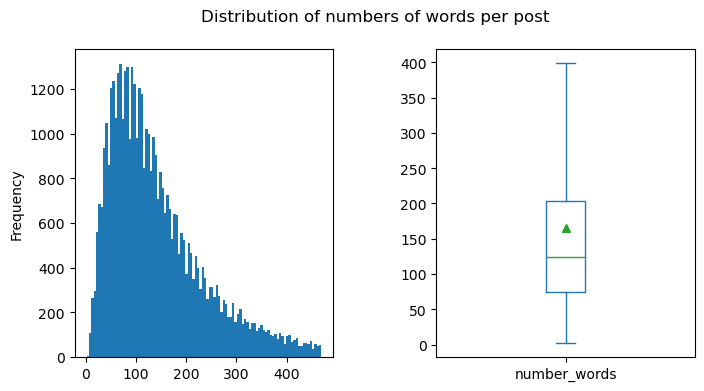

Most of messages (49%),contains 89 +/- 26 words


In [19]:

df['number_words'] = df.Body_clean.progress_apply(lambda x: len([word for word in x.split()]))


fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4))
fig.subplots_adjust(wspace=0.4)
fig.suptitle("Distribution of numbers of words per post")
df.number_words.sort_values()[:-2000].plot.hist(ax=ax0, bins=100)
df.number_words.plot.box(ax=ax1, showfliers=False, showmeans=True)
plt.show()
print(f"Most of messages ({round(100*np.sum(df.number_words.value_counts()[:100].values)/len(df))}%),\
contains {round(np.mean(df.number_words.value_counts()[:100].index))} \
+/- {round(np.std(df.number_words.value_counts()[:100].values))} words")

### analyses multivaries

In [20]:
for quantit_var in ['Score','ViewCount','AnswerCount']:
    path = quantit_var + str('~Single_most_used_tag')
    to_test = df.copy()
    fit_model = smf.ols(path, data=to_test).fit()
    print("\n---->ANOVA_LM :",quantit_var,"\n",sm.stats.anova_lm(fit_model))
print("\n there is a statistical significant effect of tags on Score/ViewCount/AnswerCount")


---->ANOVA_LM : Score 
                            df        sum_sq       mean_sq         F  \
Single_most_used_tag    191.0  1.835528e+07  96100.951286  2.950364   
Residual              47578.0  1.549738e+09  32572.573019       NaN   

                            PR(>F)  
Single_most_used_tag  4.135018e-38  
Residual                       NaN  

---->ANOVA_LM : ViewCount 
                            df        sum_sq       mean_sq        F  \
Single_most_used_tag    191.0  1.562880e+13  8.182617e+10  3.90588   
Residual              47578.0  9.967347e+14  2.094949e+10      NaN   

                            PR(>F)  
Single_most_used_tag  6.811859e-66  
Residual                       NaN  

---->ANOVA_LM : AnswerCount 
                            df         sum_sq    mean_sq         F  \
Single_most_used_tag    191.0   13069.118078  68.424702  3.953601   
Residual              47578.0  823429.197183  17.306932       NaN   

                            PR(>F)  
Single_most_used_tag  2

### bags of words

In [21]:
def make_corpus(list_of_lists):
    """ make a corpus from a list of list
    att : list of list"""
    return [word for word in list_of_lists.apply(lambda x: x.split()) for word in word] 

top_200_tags = df.Single_most_used_tag.value_counts().index.tolist()

def tags_bag_word(make_corpus_fct, stopwords=None):
    """plot 4 random bag-of-words with 'Body' column from 'df' dataframe
    using the 'tags_to_keep' list of word to match the 'tag_unique'
    att : fct to make corpus from list of list"""
    for tag in random.sample(top_200_tags,4):
        corpus = make_corpus_fct(df.loc[df.Single_most_used_tag == tag,'Body'])
        word_cloud = wordcloud.WordCloud(background_color='white',
                         stopwords=stopwords,
                         max_words=100).generate(" ".join(corpus))
        plt.title("For the tag "+tag)
        plt.imshow(word_cloud)
        plt.axis("off")
        plt.show()

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


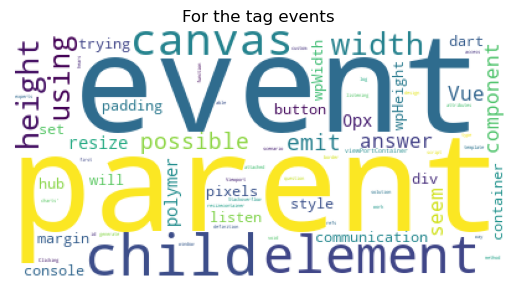

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


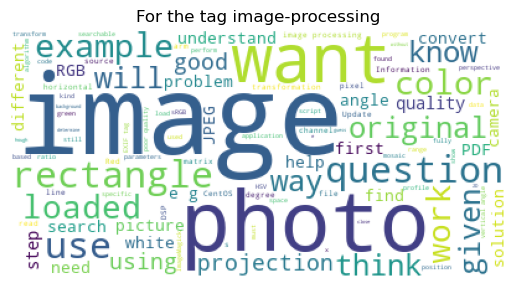

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


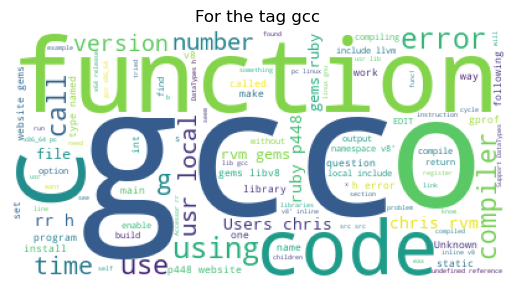

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


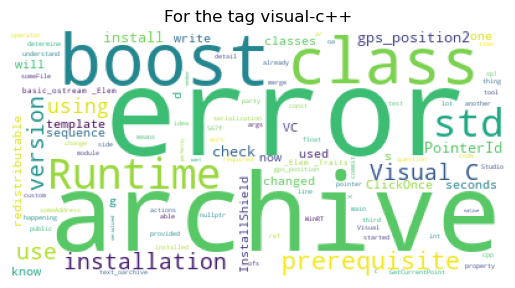

In [22]:
tags_bag_word(make_corpus)

### tokenizing

#### make stopwords = reduce dimentionality

In [23]:
# tokenize corpus
all_tokens = nltk.word_tokenize("".join(df.Body_clean.values).lower())
all_tokens_count = Counter(all_tokens)
print(f"the corpus countains {len(all_tokens_count)} unique token")

the corpus countains 445556 unique token


In [24]:
# create stop word for token appearing too little at least 10 times
min_freq_tokens = []
for token, count in all_tokens_count.most_common():
    if count < 2:
        min_freq_tokens.append(token)
stopwords_min_freq = set(min_freq_tokens)
print(f"the corpus countain {round(100*len(stopwords_min_freq)/len(all_tokens_count))}% of tokens used only once")
print(f"to remove these tokens would reduce the vocabulary from {len(all_tokens_count)} to {len(all_tokens_count)-len(stopwords_min_freq)} tokens")
print(f"it correspond to reduce the dimension of the vocabulary")

the corpus countain 65% of tokens used only once
to remove these tokens would reduce the vocabulary from 445556 to 155013 tokens
it correspond to reduce the dimension of the vocabulary


In [25]:
# tokenize corpus per tag 
max_freq_tokens = []
for tag in tqdm(tags_to_keep):
    df_temp = df.loc[df.Single_most_used_tag == tag]
    tokens_tag = nltk.word_tokenize("".join(df_temp.Body_clean.values).lower())
    max_freq_tokens.append([i for i,k in Counter(tokens_tag).most_common(200)])
words_max_freq = Counter([word for vec in max_freq_tokens for word in vec])
print("for each tag ('category'), we ")

100%|██████████| 200/200 [00:41<00:00,  4.83it/s]

for each tag ('category'), we 


In [26]:
threshold = 50
stopwords_max_freq = set([word for word, count in words_max_freq.items() if count > threshold])
print (f"\nin the dataset which tags belong to the 200 most used ones, there are {len(stopwords_max_freq)} tokens that are comon to at least {threshold} tags")
print (f"among those {len(stopwords_max_freq)} tokens, {len(stopwords_max_freq.intersection(nltk.corpus.stopwords.words('english')))} are common to the nltk.corpus.stopwords set 'english' that countains {len(nltk.corpus.stopwords.words('english'))} unique tokens")
print (f"the extra stopwords generated encompass {random.sample(list(stopwords_max_freq - set(nltk.corpus.stopwords.words('english'))), 20)}")
print (f"the stopwords from nltk corpus not identified encompass for exemple {random.sample(list(set(nltk.corpus.stopwords.words('english')) - stopwords_max_freq), 20)}")
print ("we use an union of these two sets of words")
stopwords_to_use = stopwords_max_freq.union(nltk.corpus.stopwords.words('english'))


in the dataset which tags belong to the 200 most used ones, there are 165 tokens that are comon to at least 50 tags
among those 165 tokens, 74 are common to the nltk.corpus.stopwords set 'english' that countains 179 unique tokens
the extra stopwords generated encompass ['files', 'return', 'even', 'page', 'first', 'could', 'without', 'id', 'set', 'solution', 'still', 'method', 'work', 'error', 'build', 'need', 'find', 'server', 'something', 'possible']
the stopwords from nltk corpus not identified encompass for exemple ['further', "shan't", 's', "wasn't", 'against', 'our', "weren't", "aren't", 'through', 'whom', 're', 've', 'yours', "needn't", 'herself', 'being', 'ours', 'hadn', "you'd", 'between']
we use an union of these two sets of words


In [27]:
no_stopwords = set(all_tokens)
print("we reduce dimentionality with removing words that appear too often or too little")
print(f"the original corpus contains {len(set(all_tokens))} tokens, while the corpus without unique tokens {len(set(no_stopwords)-set(stopwords_min_freq))} tokens")
print (f"\nit is possible to reduce the size of vocabulary with removing all words appearing only once in the corpus, this can also be done with the vectorizer module")
print (f"this woud retain {round(100*len(set(no_stopwords)-set(stopwords_min_freq))/len(no_stopwords))} % of the corpus only")

we reduce dimentionality with removing words that appear too often or too little
the original corpus contains 445556 tokens, while the corpus without unique tokens 155013 tokens

it is possible to reduce the size of vocabulary with removing all words appearing only once in the corpus, this can also be done with the vectorizer module
this woud retain 35 % of the corpus only


In [28]:
import pickle
stopwords_to_use = stopwords_max_freq.union(nltk.corpus.stopwords.words('english'))
with open('stopwords.pkl', 'wb') as f:
    pickle.dump(stopwords_to_use, f)

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


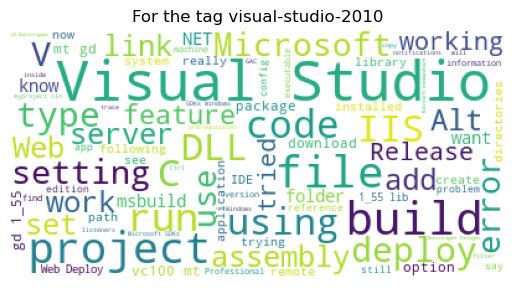

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


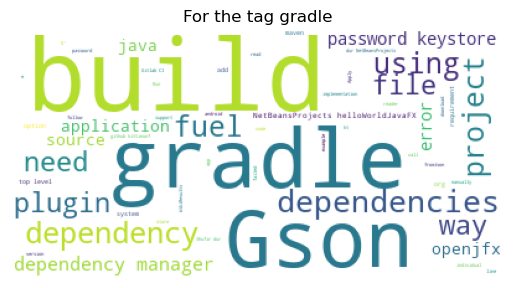

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


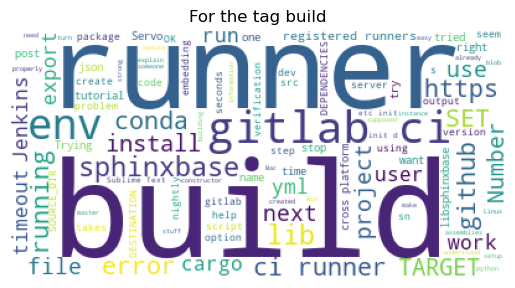

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


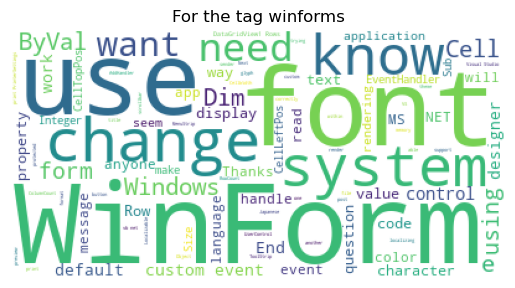

In [29]:
tags_bag_word(make_corpus)

In [30]:
def make_tokens(text):
    return nltk.word_tokenize(text.lower().strip())

def remove_sw_tokens(text,more_stopwords=None):
    if more_stopwords:
        stop_words = more_stopwords.union(nltk.corpus.stopwords.words('english'))
    else:
        stop_words = nltk.corpus.stopwords.words('english')
    return [word for word in text if word not in stop_words] 

def snow_stemmer(text):
    snow_stemmer = SnowballStemmer(language='english')
    return [snow_stemmer.stem(word) for word in text]


In [31]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
def lemma_fct(text) :
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

# Apply stemming to the n


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [32]:
nlp = spacy.load("en_core_web_sm")
def spacy(text):
    return [token.lemma_ for token in nlp(text) if not (token.is_stop or token.is_punct)]

In [33]:
tqdm.pandas()
df['tokens'] = df.Body_clean.progress_apply(make_tokens)
df['no_stopword'] = df.tokens.progress_apply(lambda x: remove_sw_tokens(x, stopwords_to_use))
df['spacy_lemma'] = df.tokens.progress_apply(lambda x: spacy(" ".join(x)))

100%|██████████| 47770/47770 [20:13<00:00, 39.38it/s]


In [34]:
df['lemma'] = df.no_stopword.progress_apply(lambda x: lemma_fct(x))
df['SnowStemmer'] = df.no_stopword.progress_apply(lambda x: snow_stemmer(x))
df['Snowlemma'] = df.SnowStemmer.progress_apply(lambda x: lemma_fct(x))

100%|██████████| 47770/47770 [00:17<00:00, 2758.69it/s]


In [35]:
# is saved all post that have at least 1 tag in the 200 most used tags list (min occurence is 8 / 50 000)
df = df[['Tags_list','Tags_200_list','Single_most_used_tag','Body_clean','tokens','no_stopword','spacy_lemma','lemma','SnowStemmer','Snowlemma']]

In [36]:
df.to_csv('Cleaned_SOF_OCP_P5.csv', encoding='utf-8', sep='\t', header=True, index=False)

In [37]:

only_10_top_tags = df.loc[df.Single_most_used_tag.isin(tags_to_keep[:10])]
data_snowstem = only_10_top_tags.lemma.values.tolist()
print("A sentence after stopwords removal and Snowball stemmatization :\n",data_snowstem[:1][0][:30])

id2word = corpora.Dictionary(data_snowstem)
texts = data_snowstem
corpus = [id2word.doc2bow(text) for text in data_snowstem]    # Term Document Frequency
print("The same sentence transformed by the bag of word :\n",corpus[:1][0][:30])
# instantiate the model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10,        # as many as there are tags selected
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)


A sentence after stopwords removal and Snowball stemmatization :
 ['let', 'say', 'model', 'mymodelmodelsmodel', 'firstfield', 'modelscharfield', 'secondfield', 'modelscharfield', 'api', 'view', 'mymodeldetailapigenericapiview', 'serializerclass', 'mymodelserializer', 'def', 'patchself', 'args', 'kwargs', 'def', 'postself', 'args', 'kwargs', 'post', 'firstfield', 'field', 'inserted', 'post', 'mandatory', 'change', 'field', 'patch']
The same sentence transformed by the bag of word :
 [(0, 1), (1, 2), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 4), (8, 4), (9, 1), (10, 2), (11, 1), (12, 2), (13, 1), (14, 1), (15, 2), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 3), (23, 1), (24, 1), (25, 4), (26, 1), (27, 3), (28, 1), (29, 1)]


In [38]:
from gensim.models.coherencemodel import CoherenceModel
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_snowstem, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n***************\nCoherence Score: ', coherence_lda)


***************
Coherence Score:  0.5485122870873848


In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word, mds="mmds", R=10)
LDAvis_prepared

/opt/conda/lib/python3.10/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.003182 -0.345158       1        1  28.039772
8      0.208490 -0.265664       2        1  15.612859
0     -0.209352 -0.244643       3        1  14.208403
9     -0.066505 -0.090908       4        1  12.703044
7      0.187273 -0.078625       5        1   9.473988
4      0.300541  0.071959       6        1   8.871498
1     -0.017614  0.318095       7        1   3.646057
5     -0.306828  0.093042       8        1   3.176682
3     -0.206425  0.243054       9        1   3.012144
6      0.113603  0.298849      10        1   1.255553, topic_info=          Term          Freq         Total Category  logprob  loglift
519    private   8829.000000   8829.000000  Default  10.0000  10.0000
560       void  11859.000000  11859.000000  Default   9.0000   9.0000
493        int  12782.000000  12782.000000  Default   8.0000   8.0000
197      image   7320.000000   7320.000000  Default   7.0000   7.0000
54        null   7457.000000   7457.000000  Default   6.0000   6.0000
...        ...           ...           ...      ...      ...      ...
15       model    419.543638   3204.160802  Topic10  -4.3946   2.3446
291      layer    222.120655    952.320603  Topic10  -5.0305   2.9219
3600  category    173.496545    472.365548  Topic10  -5.2776   3.3760
2055     shape    152.758506    507.942165  Topic10  -5.4049   3.1761
2030     numpy    153.925764    848.558237  Topic10  -5.3973   2.6705

[235 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2584      5  0.931429    abstract
2584      6  0.066425    abstract
2916      1  0.996103   advantage
4963      5  0.999144       alloc
5106      1  0.996371  allocation
...     ...       ...         ...
803       5  0.000544      window
803       7  0.000181      window
2078      3  0.010230       xcode
2078      9  0.989225       xcode
345       2  0.998879           z

[615 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 1, 10, 8, 5, 2, 6, 4, 7])

In [40]:
from sklearn.utils import all_estimators

estimators = all_estimators()

for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)

AdaBoostClassifier
BaggingClassifier
BayesianGaussianMixture
BernoulliNB
CalibratedClassifierCV
CategoricalNB
ClassifierChain
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianMixture
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier
GridSearchCV
HistGradientBoostingClassifier
KNeighborsClassifier
LabelPropagation
LabelSpreading
LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultiOutputClassifier
MultinomialNB
NuSVC
OneVsRestClassifier
Pipeline
QuadraticDiscriminantAnalysis
RFE
RFECV
RadiusNeighborsClassifier
RandomForestClassifier
RandomizedSearchCV
SGDClassifier
SVC
SelfTrainingClassifier
StackingClassifier
VotingClassifier


## fast cheking of classification + dimension reduction

In [41]:
# get dataset
df = pd.read_csv('/kaggle/input/full-dataset-ocp-sof/Cleaned_SOF_OCP_P5(2).csv', encoding='utf-8', sep='\t', lineterminator='\n')#, engine='python')
for col in ['Tags_200_list','Tags_list','tokens','no_stopword','spacy_lemma','lemma','SnowStemmer','Snowlemma']:
    df[col] = df[col].apply(lambda x: eval(x))

In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score
from sklearn.metrics import accuracy_score, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_results(y_test,yhat):
    cm = confusion_matrix(y_test, yhat)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(include_values=False, cmap='Blues')
    plt.title('Confusion matrix')
    plt.show()
    print("Accuracy: ",accuracy_score(y_test, yhat))
    print("F1 score 'macro'", f1_score(y_test, yhat, average='macro'))
    print("ARI", np.round(adjusted_rand_score(y_test, yhat),4))
    return (jaccard_score(y_test, yhat, average='macro'),
            accuracy_score(y_test, yhat), 
            f1_score(y_test, yhat, average='macro'),
            precision_score(y_test, yhat, average='macro', zero_division=1),
            recall_score(y_test, yhat, average='macro'),
            adjusted_rand_score(y_test, yhat))
eval_ = {'Model': [],
         'Jaccard':[],
        'Accuray': [],
        'f1_score': [],
        'Precision': [],
        'Recall': [],
       'ARI':[], 
        'fit_time':[],
        'predict':[]}
Results = pd.DataFrame(eval_)

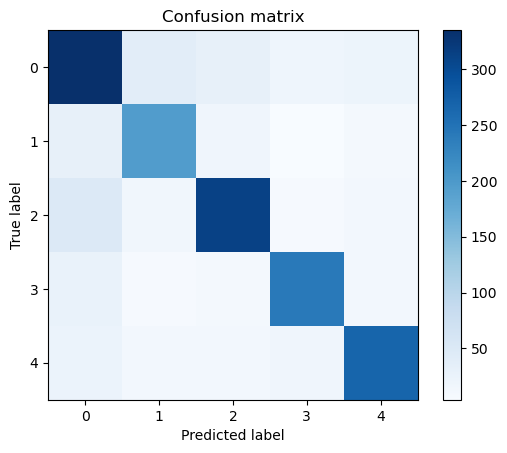

Accuracy:  0.7822814128546612
F1 score 'macro' 0.7840955835794668
ARI 0.5242


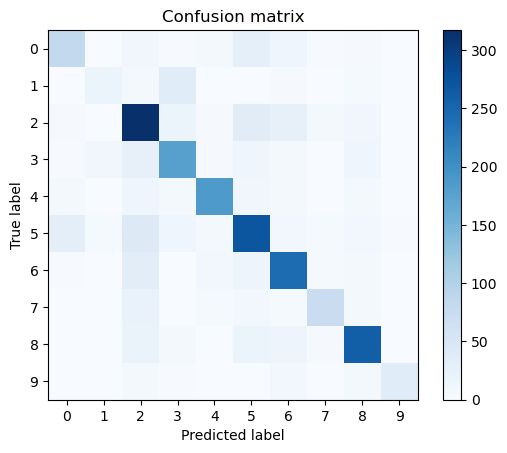

Accuracy:  0.7141020145735105
F1 score 'macro' 0.6798288807946249
ARI 0.4655


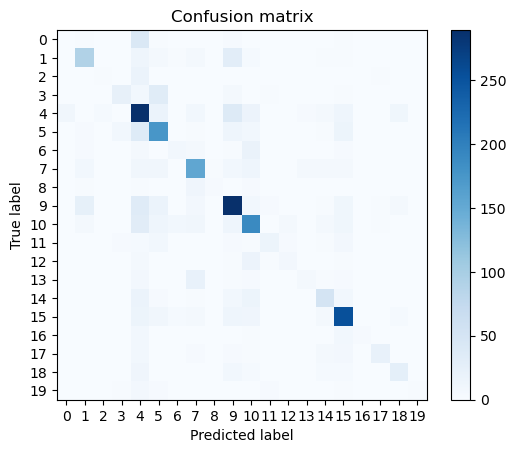

Accuracy:  0.5870120394016782
F1 score 'macro' 0.39950780241457917
ARI 0.3501


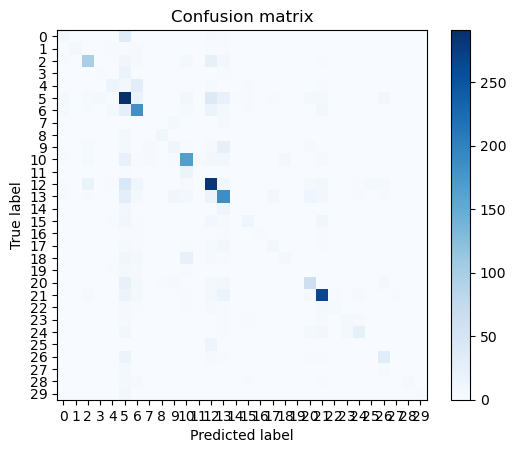

Accuracy:  0.5770020533880903
F1 score 'macro' 0.3424072827624082
ARI 0.3462


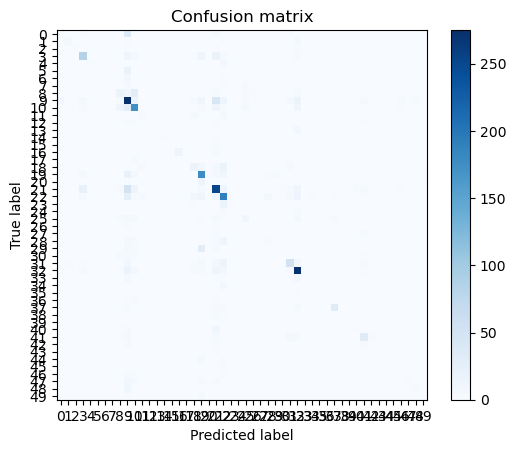

Accuracy:  0.5330524951393389
F1 score 'macro' 0.24012123908494293
ARI 0.3135


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


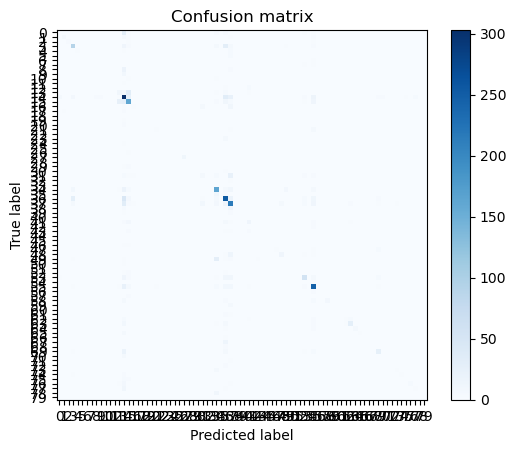

Accuracy:  0.5135725429017161
F1 score 'macro' 0.16516753004271348
ARI 0.2938


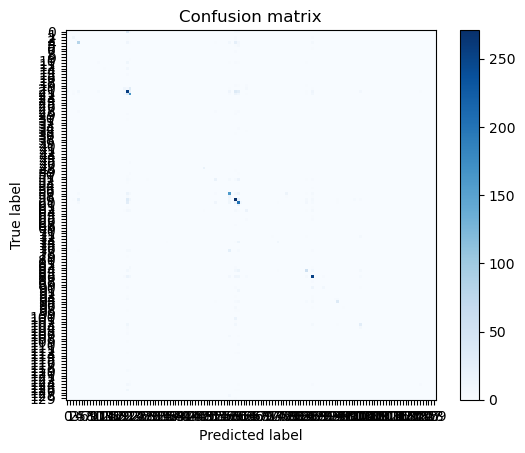

Accuracy:  0.4964928331808478
F1 score 'macro' 0.10391913185928045
ARI 0.2831


In [43]:
# without PCA for 7 different groups of tags
for n_tag in [5,10,20,30,50,80,130]:
    dft = df.sample(10000)
    tags_to_keep = dft.Single_most_used_tag.value_counts()[:n_tag].index.to_list()

    X = dft.loc[df.Single_most_used_tag.isin(tags_to_keep)]
    y = LabelEncoder().fit_transform(X.Single_most_used_tag)

    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=125, stratify=y)

    X_train_ = X_train.no_stopword.apply(lambda x: " ".join(x))

    vectorizer = CountVectorizer(min_df=2).fit(X_train_)
    X_train_vec = vectorizer.transform(X_train_)
    X_test_vec = vectorizer.transform(X_test.no_stopword.apply(lambda x: " ".join(x)))

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train_vec.toarray())
    X_test_sc = scaler.transform(X_test_vec.toarray())

    time_0 = time.time()
    clf = LogisticRegression(multi_class='ovr').fit(X_train_vec.toarray(), y_train)
    fit_time = time.time()-time_0
    time_0 = time.time()
    y_pred = clf.predict(X_test_vec.toarray())
    predict_time=time.time()-time_0
    accuracy, jaccard, f1_macro, precision, recall, ari = plot_results(y_test, y_pred)
    Results.loc[len(Results)] = ["",
                                     accuracy, jaccard, f1_macro, precision, recall, ari, fit_time,predict_time]

fit time PCA -29.56894302368164


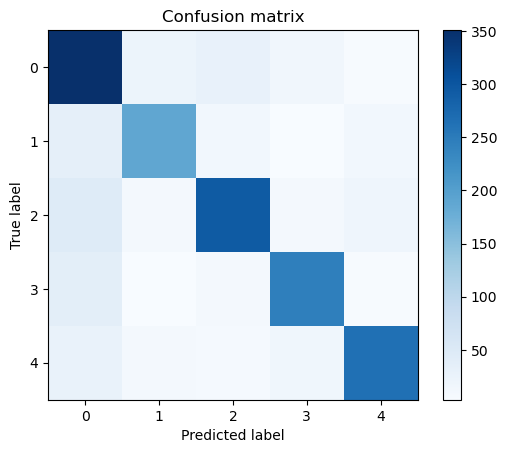

Accuracy:  0.8001193317422435
F1 score 'macro' 0.8024826137591168
ARI 0.5534
fit time PCA -84.67914962768555


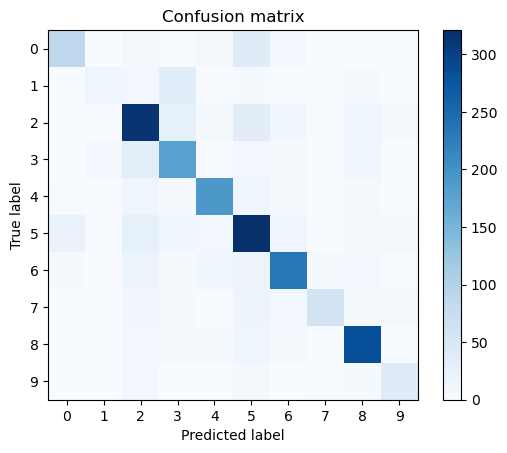

Accuracy:  0.731457800511509
F1 score 'macro' 0.6757675867816172
ARI 0.5015
fit time PCA -100.02079367637634


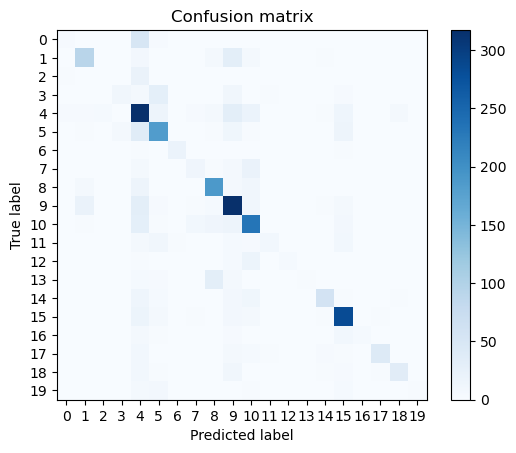

Accuracy:  0.6616842872767044
F1 score 'macro' 0.4737348773730841
ARI 0.436
fit time PCA -112.02953433990479


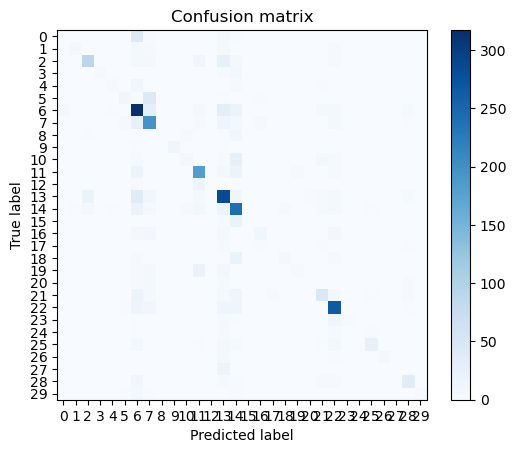

Accuracy:  0.6048830811554333
F1 score 'macro' 0.34552774624212496
ARI 0.3849
fit time PCA -117.59121894836426


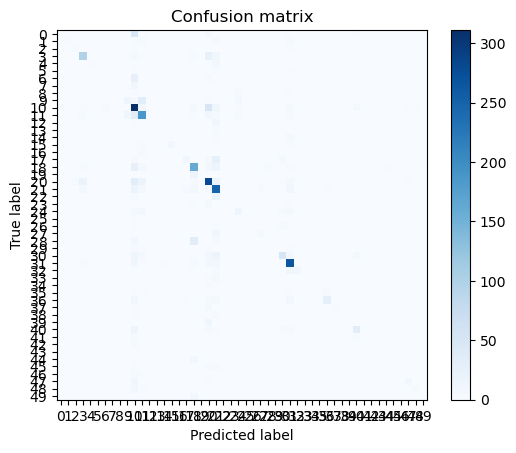

Accuracy:  0.5646982897708939
F1 score 'macro' 0.21394818796113044
ARI 0.3512
fit time PCA -119.97093057632446


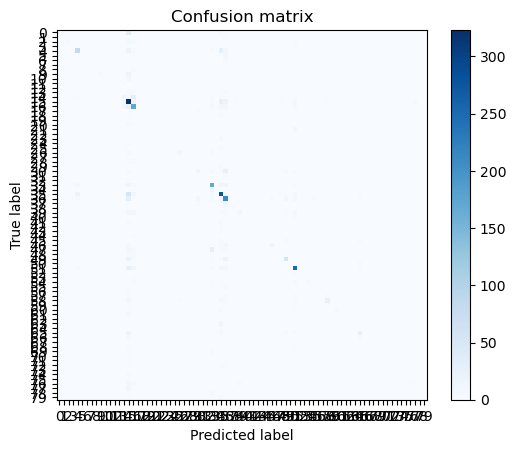

Accuracy:  0.5259375
F1 score 'macro' 0.14370239977698515
ARI 0.3012
fit time PCA -126.83457469940186


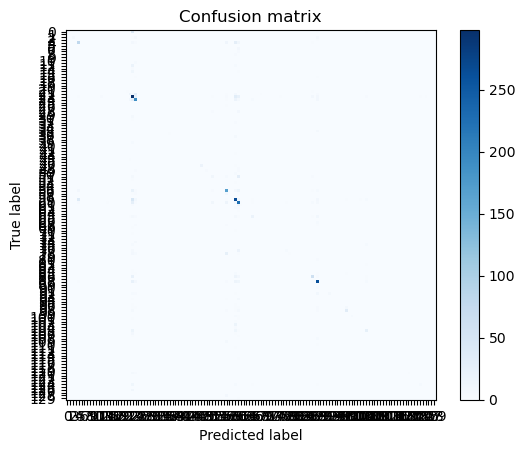

Accuracy:  0.5216463414634146
F1 score 'macro' 0.09598390708077612
ARI 0.2957


In [44]:
# with PCA for 7 different groups of tags
for n_tag in [5,10,20,30,50,80,130]:
    dft = df.sample(10000)
    tags_to_keep = dft.Single_most_used_tag.value_counts()[:n_tag].index.to_list()

    X = dft.loc[df.Single_most_used_tag.isin(tags_to_keep)]
    y = LabelEncoder().fit_transform(X.Single_most_used_tag)

    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=125, stratify=y)

    X_train_ = X_train.no_stopword.apply(lambda x: " ".join(x))

    vectorizer = CountVectorizer(min_df=2).fit(X_train_)
    X_train_vec = vectorizer.transform(X_train_)
    X_test_vec = vectorizer.transform(X_test.no_stopword.apply(lambda x: " ".join(x)))

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train_vec.toarray())
    X_test_sc = scaler.transform(X_test_vec.toarray())
    
    pca = PCA(n_components=3000)
    time_1=time.time()
    pca.fit(X_train_sc)
    print("fit time PCA", time_1-time.time())

    time_0 = time.time()
    clf = LogisticRegression(multi_class='ovr').fit(pca.transform(X_train_vec.toarray()), y_train)
    fit_time = time.time()-time_0
    time_0 = time.time()
    y_pred = clf.predict(pca.transform(X_test_vec.toarray()))
    predict_time=time.time()-time_0
    accuracy, jaccard, f1_macro, precision, recall, ari = plot_results(y_test, y_pred)
    Results.loc[len(Results)] = ["",
                                     accuracy, jaccard, f1_macro, precision, recall, ari, fit_time,predict_time]

In [45]:
Results

,Model,Jaccard,Accuray,f1_score,Precision,Recall,ARI,fit_time,predict
0,,0.646238,0.782281,0.784096,0.785507,0.783179,0.524175,11.150240,0.158916
1,,0.526929,0.714102,0.679829,0.721278,0.656601,0.465466,29.409802,0.304355
2,,0.272903,0.587012,0.399508,0.477577,0.375066,0.350072,72.903160,0.290828
3,,0.232367,0.577002,0.342407,0.416520,0.315333,0.346219,125.594919,0.354247
4,,0.157834,0.533052,0.240121,0.388773,0.217064,0.313463,201.132377,0.399493
5,,0.107032,0.513573,0.165168,0.437283,0.148549,0.293806,305.761965,0.387662
6,,0.067224,0.496493,0.103919,0.592108,0.093650,0.283143,441.947469,0.774056
7,,0.671022,0.800119,0.802483,0.811259,0.796922,0.553421,5.393296,1.515154
8,,0.526683,0.731458,0.675768,0.714958,0.658586,0.501531,10.444819,2.559193
9,,0.350916,0.661684,0.473735,0.612681,0.444934,0.435987,17.133821,3.379286


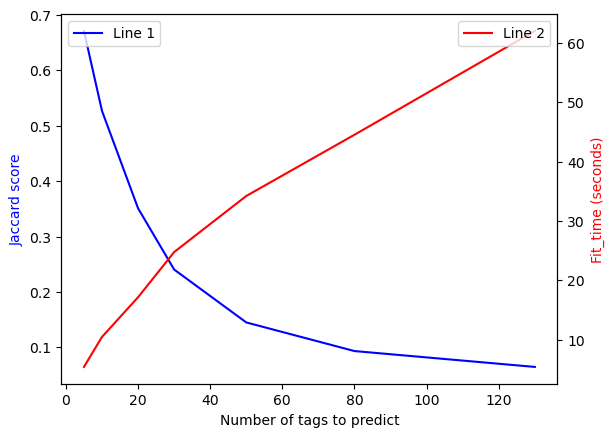

In [46]:
x = [5,10,20,30,50,80,130]
y1 = Results.loc[7:,['Jaccard']]
y2 = Results.loc[7:,['fit_time']]

fig, ax1 = plt.subplots()

ax1.plot(x, y1, 'b-', label='Line 1')
ax1.set_xlabel('Number of tags to predict')
ax1.set_ylabel('Jaccard score', color='b')

ax2 = ax1.twinx()
ax2.plot(x, y2, 'r-', label='Line 2')
ax2.set_ylabel('Fit_time (seconds)', color='r')


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

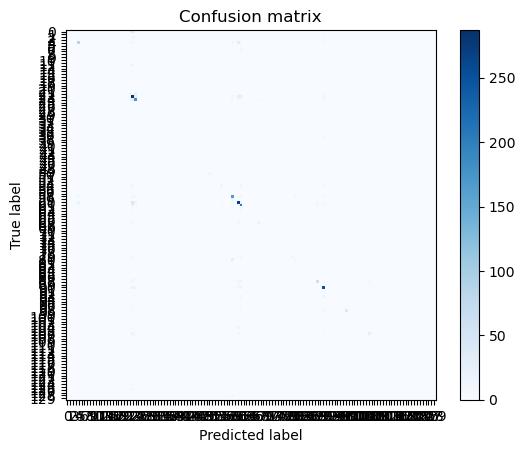

Accuracy:  0.5109689213893968
F1 score 'macro' 0.10969970139152924
ARI 0.2974


In [47]:
dft = df.sample(10000)
tags_to_keep = dft.Single_most_used_tag.value_counts()[:130].index.to_list()

X = dft.loc[df.Single_most_used_tag.isin(tags_to_keep)]
y = LabelEncoder().fit_transform(X.Single_most_used_tag)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=125, stratify=y)


X_train_ = X_train.no_stopword.apply(lambda x: " ".join(x))

vectorizer = CountVectorizer(min_df=2).fit(X_train_)
X_train_vec = vectorizer.transform(X_train_)
X_test_vec = vectorizer.transform(X_test.no_stopword.apply(lambda x: " ".join(x)))



scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_vec.toarray())
X_test_sc = scaler.transform(X_test_vec.toarray())
time_0 = time.time()
clf = LogisticRegression(multi_class='ovr').fit(X_train_vec, y_train)
fit_time = time.time()-time_0
time_0 = time.time()
y_pred = clf.predict(X_test_vec)
predict_time=time.time()-time_0
accuracy, jaccard, f1_macro, precision, recall, ari = plot_results(y_test, y_pred)
Results.loc[len(Results)] = ["",
                                     accuracy, jaccard, f1_macro, precision, recall, ari, fit_time,predict_time]

fit time PCA -126.17924571037292


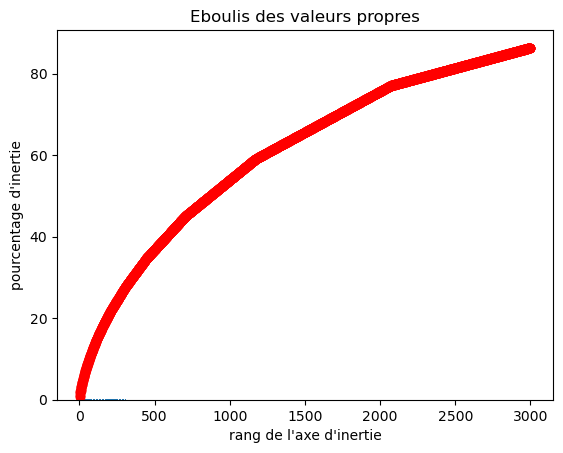

In [48]:
# test plot so see how much variance is explained

n_components = 3000
pca = PCA(n_components=n_components)
time_1=time.time()
pca.fit(X_train_sc)
print("fit time PCA", time_1-time.time())
pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)

scree_cum = scree.cumsum()
x_list = range(1, n_components+1)

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

the vocabulary for the sampled df comprises 16710 words
PCA allow to reduce this vocabularu to 1000 variables that can explain 100% of variations


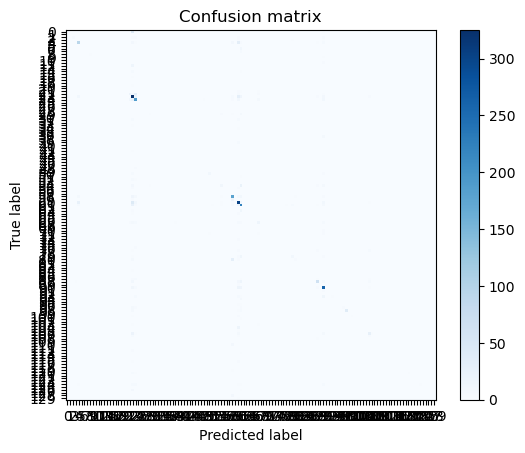

Accuracy:  0.5463132236441195
F1 score 'macro' 0.10027015882608555
ARI 0.3405


In [49]:
print(f"the vocabulary for the sampled df comprises {X_train_sc.shape[1]} words")
print("PCA allow to reduce this vocabularu to 1000 variables that can explain 100% of variations")


time_0 = time.time()
clf = LogisticRegression(multi_class='ovr').fit(pca.transform(X_train_vec.toarray()), y_train)
fit_time=time.time()-time_0
time_0 = time.time()
y_pred = clf.predict(pca.transform(X_test_vec.toarray()))
predict_time=time.time()-time_0

accuracy, jaccard, f1_macro, precision, recall, ari = plot_results(y_test, y_pred)
Results.loc[len(Results)] = ["",
                                     accuracy, jaccard, f1_macro, precision, recall, ari, fit_time,predict_time]

In [50]:
Results

,Model,Jaccard,Accuray,f1_score,Precision,Recall,ARI,fit_time,predict
0,,0.646238,0.782281,0.784096,0.785507,0.783179,0.524175,11.150240,0.158916
1,,0.526929,0.714102,0.679829,0.721278,0.656601,0.465466,29.409802,0.304355
2,,0.272903,0.587012,0.399508,0.477577,0.375066,0.350072,72.903160,0.290828
3,,0.232367,0.577002,0.342407,0.416520,0.315333,0.346219,125.594919,0.354247
4,,0.157834,0.533052,0.240121,0.388773,0.217064,0.313463,201.132377,0.399493
5,,0.107032,0.513573,0.165168,0.437283,0.148549,0.293806,305.761965,0.387662
6,,0.067224,0.496493,0.103919,0.592108,0.093650,0.283143,441.947469,0.774056
7,,0.671022,0.800119,0.802483,0.811259,0.796922,0.553421,5.393296,1.515154
8,,0.526683,0.731458,0.675768,0.714958,0.658586,0.501531,10.444819,2.559193
9,,0.350916,0.661684,0.473735,0.612681,0.444934,0.435987,17.133821,3.379286
